# 🎨 Notebook 03: Feature Visualization

## Generación de Imágenes que Activan Neuronas

---

## 📚 Objetivos del Notebook

En este notebook implementaremos **Feature Visualization**, una técnica para entender qué buscan las neuronas individuales generando imágenes sintéticas que las activan maximalmente.

### ✅ Qué aprenderemos:

1. **Activation Maximization**: Optimizar un input para maximizar la activación de una neurona
2. **Gradient Ascent**: Subir por el gradiente para encontrar el input óptimo
3. **Regularización**: Técnicas para generar imágenes interpretables
4. **Feature Visualization por Capas**: Ver qué detecta cada capa de la red

---

## 🔬 Conceptos Fundamentales

### ¿Qué es Feature Visualization?

**Feature Visualization** consiste en generar una imagen sintética que maximice la activación de una neurona específica.

**Proceso:**
1. Empezar con una imagen aleatoria (ruido)
2. Hacer forward pass por la red
3. Calcular la activación de la neurona objetivo
4. Calcular el gradiente de la activación respecto a la imagen
5. Actualizar la imagen en dirección del gradiente (gradient ascent)
6. Repetir hasta convergencia

**Resultado:** Una imagen que muestra qué "busca" esa neurona

### Regularización

Sin regularización, las imágenes generadas serían ruido incomprensible. Usamos:

1. **Total Variation (TV) Loss**: Penaliza cambios bruscos entre píxeles adyacentes
2. **L2 Norm**: Penaliza valores de píxeles muy grandes
3. **Blurring**: Suavizado periódico de la imagen
4. **Jittering**: Pequeñas traslaciones aleatorias

---

## 📦 Imports y Configuración Inicial

In [1]:
# Imports estándar
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, Tuple, List, Dict
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Torchvision
from torchvision import transforms
from torchvision.utils import save_image

# PIL para procesamiento de imágenes
from PIL import Image, ImageFilter

# Configuración de matplotlib
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Agregar el directorio raíz al path
sys.path.append('..')

# Imports de nuestro proyecto
from src.models.model_loader import ModelLoader
from src.utils.hooks import ActivationHook
from src.utils.image_loader import ImageLoader

# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")

🖥️ Device: cpu


## 🔧 Funciones de Utilidad para Feature Visualization

In [2]:
def preprocess_image(img: torch.Tensor) -> torch.Tensor:
    """
    Preprocesa una imagen para visualización (desnormalización y clipping).
    
    Args:
        img: Tensor [C, H, W] o [1, C, H, W] normalizado
    
    Returns:
        Tensor desnormalizado y con valores en [0, 1]
    """
    # Remover batch dimension si existe
    if img.dim() == 4:
        img = img.squeeze(0)
    
    # Desnormalizar con stats de ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img.device)
    
    img = img * std + mean
    
    # Clip a rango válido
    img = torch.clamp(img, 0, 1)
    
    return img


def deprocess_image(img: torch.Tensor) -> np.ndarray:
    """
    Convierte un tensor de imagen a numpy array para visualización.
    
    Args:
        img: Tensor [C, H, W] o [1, C, H, W]
    
    Returns:
        Array numpy [H, W, C] con valores en [0, 255]
    """
    img = preprocess_image(img)
    
    # Convertir a numpy y cambiar orden de dimensiones
    img_np = img.detach().cpu().numpy().transpose(1, 2, 0)
    
    # Escalar a [0, 255]
    img_np = (img_np * 255).astype(np.uint8)
    
    return img_np


def total_variation_loss(img: torch.Tensor) -> torch.Tensor:
    """
    Calcula Total Variation Loss para regularización.
    Penaliza cambios bruscos entre píxeles adyacentes.
    
    Args:
        img: Tensor [1, C, H, W]
    
    Returns:
        Scalar de pérdida
    """
    # Diferencias horizontales y verticales
    diff_h = torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :])
    diff_v = torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1])
    
    # Suma de diferencias
    tv_loss = torch.mean(diff_h) + torch.mean(diff_v)
    
    return tv_loss


def l2_norm_loss(img: torch.Tensor) -> torch.Tensor:
    """
    Calcula L2 norm loss para regularización.
    Penaliza valores de píxeles muy grandes.
    
    Args:
        img: Tensor [1, C, H, W]
    
    Returns:
        Scalar de pérdida
    """
    return torch.mean(img ** 2)


def apply_jitter(img: torch.Tensor, jitter_pixels: int = 8) -> torch.Tensor:
    """
    Aplica jittering (traslación aleatoria) a una imagen.
    
    Args:
        img: Tensor [1, C, H, W]
        jitter_pixels: Máximo desplazamiento en píxeles
    
    Returns:
        Imagen con jitter aplicado
    """
    # Desplazamientos aleatorios
    ox = np.random.randint(-jitter_pixels, jitter_pixels + 1)
    oy = np.random.randint(-jitter_pixels, jitter_pixels + 1)
    
    # Aplicar traslación usando roll
    img = torch.roll(img, shifts=(ox, oy), dims=(2, 3))
    
    return img


def apply_blur(img: torch.Tensor, sigma: float = 0.5) -> torch.Tensor:
    """
    Aplica blur gaussiano a una imagen.
    
    Args:
        img: Tensor [1, C, H, W]
        sigma: Desviación estándar del filtro gaussiano
    
    Returns:
        Imagen con blur aplicado
    """
    # Convertir a PIL
    img_np = deprocess_image(img)
    img_pil = Image.fromarray(img_np)
    
    # Aplicar filtro gaussiano
    img_blurred = img_pil.filter(ImageFilter.GaussianBlur(radius=sigma))
    
    # Convertir de vuelta a tensor
    img_array = np.array(img_blurred).astype(np.float32) / 255.0
    
    # Normalizar con stats de ImageNet
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    img_normalized = (img_array - mean) / std
    
    # Convertir a tensor
    img_tensor = torch.from_numpy(img_normalized.transpose(2, 0, 1)).float()
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    return img_tensor


print("✅ Funciones de utilidad cargadas")

✅ Funciones de utilidad cargadas


## 🎨 Clase Principal: FeatureVisualizer

Esta clase implementa la técnica de Activation Maximization para generar imágenes que activan neuronas.

In [3]:
class FeatureVisualizer:
    """
    Clase para generar visualizaciones de features usando Activation Maximization.
    
    Esta clase implementa gradient ascent para encontrar imágenes que maximizan
    la activación de neuronas específicas en capas de una red neuronal.
    """
    
    def __init__(
        self,
        model: nn.Module,
        target_layer: str,
        device: torch.device = None
    ):
        """
        Inicializa el visualizador.
        
        Args:
            model: Modelo de PyTorch
            target_layer: Nombre de la capa objetivo (ej: 'layer3.1.conv2')
            device: Device para cómputo (CPU/GPU)
        """
        self.model = model.to(device)
        self.model.eval()
        self.target_layer = target_layer
        self.device = device if device else torch.device('cpu')
        
        # Registrar hook para capturar activaciones
        self.hook = ActivationHook(self.model, [target_layer])
        self.hook.register_hooks()
        
        print(f"✅ FeatureVisualizer inicializado")
        print(f"   Capa objetivo: {target_layer}")
        print(f"   Device: {self.device}")
    
    
    def generate_visualization(
        self,
        neuron_index: int,
        image_size: Tuple[int, int] = (224, 224),
        iterations: int = 100,
        learning_rate: float = 0.1,
        tv_weight: float = 1e-4,
        l2_weight: float = 1e-5,
        blur_freq: int = 4,
        blur_sigma: float = 0.5,
        jitter: bool = True,
        verbose: bool = True
    ) -> Tuple[np.ndarray, List[float]]:
        """
        Genera una imagen que maximiza la activación de una neurona específica.
        
        Args:
            neuron_index: Índice de la neurona a visualizar
            image_size: Tamaño de la imagen a generar (H, W)
            iterations: Número de iteraciones de optimización
            learning_rate: Tasa de aprendizaje para gradient ascent
            tv_weight: Peso de Total Variation loss
            l2_weight: Peso de L2 norm loss
            blur_freq: Frecuencia de aplicación de blur (cada N iteraciones)
            blur_sigma: Intensidad del blur gaussiano
            jitter: Si aplicar jittering aleatorio
            verbose: Si imprimir progreso
        
        Returns:
            Tuple con:
                - Imagen generada como array numpy [H, W, C]
                - Lista de valores de activación por iteración
        """
        # Inicializar imagen con ruido aleatorio
        img = self._initialize_image(image_size)
        img.requires_grad_(True)
        
        # Optimizador (gradient ascent = Adam con lr positivo)
        optimizer = Adam([img], lr=learning_rate)
        
        # Historia de activaciones
        activation_history = []
        
        # Barra de progreso
        pbar = tqdm(range(iterations), desc=f"🎨 Generando visualización para neurona {neuron_index}",
                   disable=not verbose)
        
        for i in pbar:
            # Aplicar jitter si está habilitado
            if jitter:
                img_jittered = apply_jitter(img)
            else:
                img_jittered = img
            
            # Forward pass
            optimizer.zero_grad()
            _ = self.model(img_jittered)
            
            # Obtener activación de la neurona objetivo
            activations = self.hook.get_activations()
            layer_activation = activations[self.target_layer]
            
            # Extraer activación de la neurona específica
            # layer_activation shape: [1, C, H, W]
            neuron_activation = layer_activation[0, neuron_index, :, :]
            
            # Calcular activación promedio (objetivo a maximizar)
            activation_value = neuron_activation.mean()
            
            # Calcular regularización
            tv_loss = total_variation_loss(img)
            l2_loss = l2_norm_loss(img)
            
            # Loss total (negativos porque queremos MAXIMIZAR la activación)
            # Gradient descent minimiza, entonces negativizamos para hacer gradient ascent
            total_loss = -activation_value + tv_weight * tv_loss + l2_weight * l2_loss
            
            # Backward pass
            total_loss.backward()
            
            # Actualizar imagen
            optimizer.step()
            
            # Aplicar blur periódicamente
            if blur_freq > 0 and (i + 1) % blur_freq == 0:
                with torch.no_grad():
                    img.data = apply_blur(img, sigma=blur_sigma)
            
            # Guardar activación
            activation_history.append(activation_value.item())
            
            # Actualizar barra de progreso
            if verbose and i % 10 == 0:
                pbar.set_postfix({
                    'activation': f'{activation_value.item():.4f}',
                    'tv_loss': f'{tv_loss.item():.4f}',
                    'l2_loss': f'{l2_loss.item():.6f}'
                })
            
            # Limpiar activaciones para siguiente iteración
            self.hook.clear_activations()
        
        # Convertir imagen final a numpy
        final_img = deprocess_image(img)
        
        return final_img, activation_history
    
    
    def generate_multiple_visualizations(
        self,
        neuron_indices: List[int],
        **kwargs
    ) -> Dict[int, Tuple[np.ndarray, List[float]]]:
        """
        Genera visualizaciones para múltiples neuronas.
        
        Args:
            neuron_indices: Lista de índices de neuronas
            **kwargs: Argumentos para generate_visualization()
        
        Returns:
            Dict con {neuron_index: (imagen, historial_activación)}
        """
        results = {}
        
        for idx in neuron_indices:
            print(f"\n{'='*60}")
            print(f"Procesando neurona {idx}")
            print(f"{'='*60}")
            
            img, history = self.generate_visualization(idx, **kwargs)
            results[idx] = (img, history)
        
        return results
    
    
    def _initialize_image(self, image_size: Tuple[int, int]) -> torch.Tensor:
        """
        Inicializa una imagen con ruido aleatorio normalizado.
        
        Args:
            image_size: (height, width)
        
        Returns:
            Tensor [1, 3, H, W] con ruido normalizado
        """
        # Ruido uniforme en [0, 1]
        img = torch.rand(1, 3, image_size[0], image_size[1])
        
        # Normalizar con stats de ImageNet
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        img = (img - mean) / std
        
        # Mover a device
        img = img.to(self.device)
        
        return img
    
    
    def cleanup(self):
        """
        Libera recursos y remueve hooks.
        """
        self.hook.remove_hooks()
        print("✅ Recursos liberados")


print("✅ Clase FeatureVisualizer definida")

✅ Clase FeatureVisualizer definida


## 📊 Funciones de Visualización

In [4]:
def plot_feature_visualization(
    img: np.ndarray,
    activation_history: List[float],
    neuron_index: int,
    layer_name: str,
    figsize: Tuple[int, int] = (12, 4)
):
    """
    Visualiza el resultado de feature visualization junto con la curva de activación.
    
    Args:
        img: Imagen generada [H, W, C]
        activation_history: Lista de valores de activación
        neuron_index: Índice de la neurona
        layer_name: Nombre de la capa
        figsize: Tamaño de la figura
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Subplot 1: Imagen generada
    axes[0].imshow(img)
    axes[0].set_title(f'Feature Visualization\nCapa: {layer_name}\nNeurona: {neuron_index}',
                     fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # Subplot 2: Curva de activación
    axes[1].plot(activation_history, linewidth=2, color='#2E86AB')
    axes[1].set_xlabel('Iteración', fontsize=10)
    axes[1].set_ylabel('Activación Promedio', fontsize=10)
    axes[1].set_title('Evolución de la Activación', fontsize=11, fontweight='bold')
    axes[1].grid(True, alpha=0.3, linestyle='--')
    
    # Añadir información de activación final
    final_activation = activation_history[-1]
    axes[1].axhline(y=final_activation, color='red', linestyle='--', alpha=0.5,
                   label=f'Final: {final_activation:.4f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


def plot_multiple_features(
    results: Dict[int, Tuple[np.ndarray, List[float]]],
    layer_name: str,
    num_cols: int = 4,
    figsize_per_image: Tuple[int, int] = (3, 3)
):
    """
    Visualiza múltiples feature visualizations en una grilla.
    
    Args:
        results: Dict con {neuron_index: (imagen, historial)}
        layer_name: Nombre de la capa
        num_cols: Número de columnas en la grilla
        figsize_per_image: Tamaño de cada subplot
    """
    num_neurons = len(results)
    num_rows = (num_neurons + num_cols - 1) // num_cols
    
    figsize = (figsize_per_image[0] * num_cols, figsize_per_image[1] * num_rows)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Feature Visualizations - {layer_name}', fontsize=14, fontweight='bold', y=1.02)
    
    for idx, (neuron_idx, (img, history)) in enumerate(results.items()):
        row = idx // num_cols
        col = idx % num_cols
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'Neurona {neuron_idx}\nAct: {history[-1]:.3f}',
                                fontsize=9)
        axes[row, col].axis('off')
    
    # Ocultar subplots vacíos
    for idx in range(num_neurons, num_rows * num_cols):
        row = idx // num_cols
        col = idx % num_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


def compare_layer_features(
    visualizations: Dict[str, Dict[int, Tuple[np.ndarray, List[float]]]],
    num_neurons_per_layer: int = 4,
    figsize: Tuple[int, int] = (16, 12)
):
    """
    Compara feature visualizations de múltiples capas.
    
    Args:
        visualizations: Dict con {layer_name: {neuron_idx: (img, history)}}
        num_neurons_per_layer: Número de neuronas a mostrar por capa
        figsize: Tamaño de la figura
    """
    num_layers = len(visualizations)
    
    fig, axes = plt.subplots(num_layers, num_neurons_per_layer, figsize=figsize)
    
    if num_layers == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Comparación de Features por Capa', fontsize=16, fontweight='bold', y=1.00)
    
    for layer_idx, (layer_name, layer_results) in enumerate(visualizations.items()):
        # Tomar las primeras N neuronas
        neuron_items = list(layer_results.items())[:num_neurons_per_layer]
        
        for neuron_idx, (neuron_id, (img, history)) in enumerate(neuron_items):
            axes[layer_idx, neuron_idx].imshow(img)
            
            if neuron_idx == 0:
                axes[layer_idx, neuron_idx].set_ylabel(layer_name, fontsize=10, fontweight='bold')
            
            if layer_idx == 0:
                axes[layer_idx, neuron_idx].set_title(f'Neurona {neuron_id}', fontsize=9)
            
            axes[layer_idx, neuron_idx].axis('off')
    
    plt.tight_layout()
    plt.show()


print("✅ Funciones de visualización cargadas")

✅ Funciones de visualización cargadas


## 🚀 Experimento 1: Feature Visualization de una Neurona

Empezaremos generando la visualización de una sola neurona para entender el proceso.

In [5]:
# Cargar modelo
print("🔧 Cargando modelo ResNet-18...")
loader = ModelLoader('resnet18', pretrained=True, device=device)
model = loader.load_model()

print("\n📊 Arquitectura del modelo:")
print(f"   Total de parámetros: {loader.get_architecture_info()['total_params']:,}")
print(f"   Número de capas: {loader.get_architecture_info()['num_layers']}")

INFO:src.models.model_loader:ModelLoader inicializado: resnet18
INFO:src.models.model_loader:Device: cpu
INFO:src.models.model_loader:Pre-trained: True
INFO:src.models.model_loader:Cargando modelo resnet18...
INFO:src.models.model_loader:Descargando pesos pre-entrenados de ImageNet...


🔧 Cargando modelo ResNet-18...


INFO:src.models.model_loader:✅ Modelo resnet18 cargado exitosamente
INFO:src.models.model_loader:   Device: cpu
INFO:src.models.model_loader:   Parámetros: 11,689,512



📊 Arquitectura del modelo:
   Total de parámetros: 11,689,512
   Número de capas: 68


In [20]:
# Seleccionar capa objetivo
# Vamos a visualizar una capa intermedia (layer2)
target_layer = 'layer2.1.conv2'
neuron_index = 44  # Neurona arbitraria

print(f"🎯 Objetivo:")
print(f"   Capa: {target_layer}")
print(f"   Neurona: {neuron_index}")

# Crear visualizador
visualizer = FeatureVisualizer(model, target_layer, device=device)

INFO:src.utils.hooks:ActivationHook inicializado con 1 capas objetivo
INFO:src.utils.hooks:Registrando hooks...
INFO:src.utils.hooks:✅ 1 hooks registrados exitosamente


🎯 Objetivo:
   Capa: layer2.1.conv2
   Neurona: 44
✅ FeatureVisualizer inicializado
   Capa objetivo: layer2.1.conv2
   Device: cpu


In [23]:
# Generar visualización
print("\n🎨 Generando feature visualization...\n")

img, history = visualizer.generate_visualization(
    neuron_index=neuron_index,
    image_size=(224, 224),
    iterations=100,
    learning_rate=0.1,
    tv_weight=1e-4,
    l2_weight=1e-5,
    blur_freq=4,
    blur_sigma=0.5,
    jitter=True,
    verbose=True
)

# Encuentra el pico manualmente
best_idx = np.argmax(history)
print(f"Mejor activación: {history[best_idx]:.4f} en iter {best_idx}")

# Re-genera hasta ese punto
img_best, _ = visualizer.generate_visualization(
    neuron_index=44,
    iterations=best_idx,  # ← DETÉN EN EL PICO
)

print(f"\n✅ Visualización generada")
print(f"   Activación final: {history[-1]:.4f}")
print(f"   Activación inicial: {history[0]:.4f}")
print(f"   Incremento: {history[-1] - history[0]:.4f} ({((history[-1]/history[0])-1)*100:.1f}%)")


🎨 Generando feature visualization...



🎨 Generando visualización para neurona 44:   0%|          | 0/100 [00:00<?, ?it/s]

Mejor activación: -0.1371 en iter 72


🎨 Generando visualización para neurona 44:   0%|          | 0/72 [00:00<?, ?it/s]


✅ Visualización generada
   Activación final: -0.1842
   Activación inicial: -0.4583
   Incremento: 0.2741 (-59.8%)


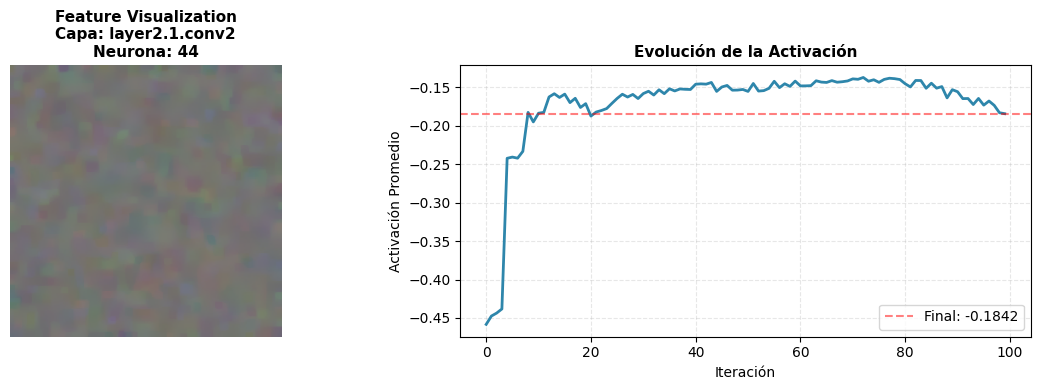

In [24]:
# Visualizar resultado
plot_feature_visualization(
    img=img,
    activation_history=history,
    neuron_index=neuron_index,
    layer_name=target_layer
)

### 🔍 Interpretación del Resultado

**¿Qué estamos viendo?**
- La imagen generada muestra patrones/texturas que maximalmente activan esa neurona
- La curva de activación muestra cómo aumenta durante la optimización
- Los patrones pueden ser bordes, texturas, formas geométricas, etc.

**Observaciones típicas:**
- **Capas tempranas** (conv1, layer1): Detectan bordes, colores, texturas simples
- **Capas medias** (layer2, layer3): Detectan formas, combinaciones de texturas
- **Capas tardías** (layer4): Detectan partes de objetos, conceptos más abstractos

## 🧪 Experimento 2: Visualizaciones de Múltiples Neuronas

Ahora generaremos visualizaciones para varias neuronas de la misma capa.

In [9]:
# Seleccionar neuronas aleatorias de la capa
np.random.seed(42)
num_neurons_to_visualize = 8

# Las capas conv tienen múltiples canales (neuronas)
# Para layer2.1.conv2 en ResNet-18, hay 128 canales
neuron_indices = np.random.choice(128, size=num_neurons_to_visualize, replace=False).tolist()

print(f"🎯 Neuronas seleccionadas de {target_layer}:")
print(f"   {neuron_indices}")

🎯 Neuronas seleccionadas de layer2.1.conv2:
   [55, 40, 19, 31, 98, 56, 69, 104]


In [10]:
# Generar visualizaciones para todas las neuronas
print(f"\n🎨 Generando {num_neurons_to_visualize} visualizaciones...\n")

results = visualizer.generate_multiple_visualizations(
    neuron_indices=neuron_indices,
    image_size=(224, 224),
    iterations=150,  # Menos iteraciones para velocidad
    learning_rate=0.1,
    tv_weight=1e-4,
    l2_weight=1e-5,
    blur_freq=4,
    jitter=True,
    verbose=False  # Desactivar verbose para múltiples visualizaciones
)

print(f"\n✅ {len(results)} visualizaciones generadas")


🎨 Generando 8 visualizaciones...


Procesando neurona 55

Procesando neurona 40

Procesando neurona 19

Procesando neurona 31

Procesando neurona 98

Procesando neurona 56

Procesando neurona 69

Procesando neurona 104

✅ 8 visualizaciones generadas


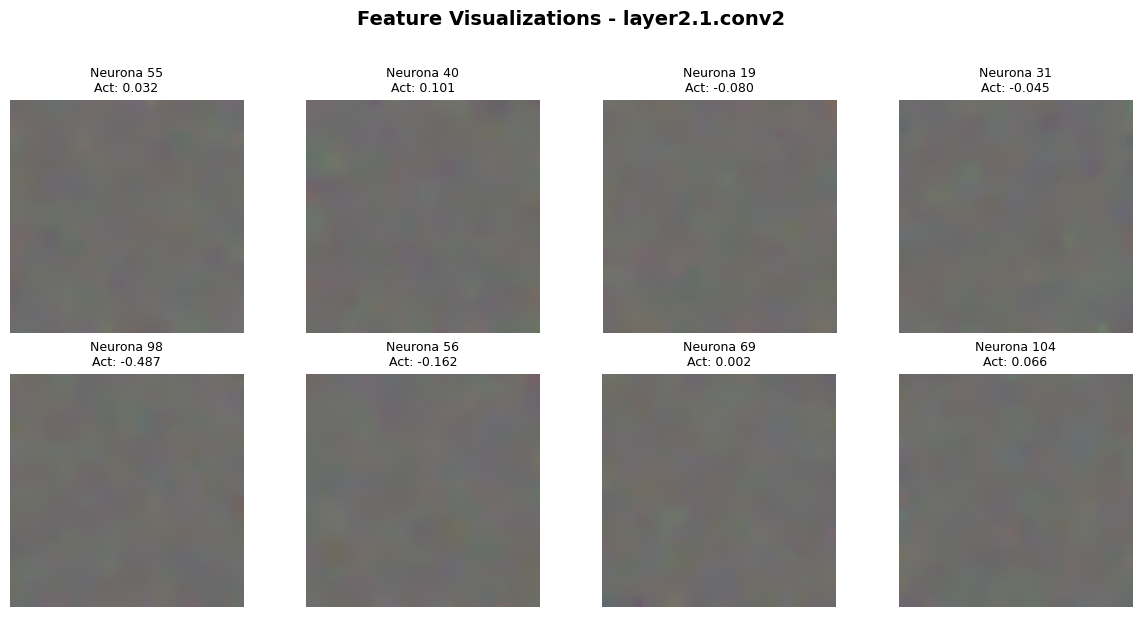

In [11]:
# Visualizar todas las neuronas juntas
plot_multiple_features(
    results=results,
    layer_name=target_layer,
    num_cols=4,
    figsize_per_image=(3, 3)
)

### 📊 Análisis de Diversidad de Features

Analicemos la diversidad de features aprendidos en esta capa.

📊 Estadísticas de Activaciones:
   Media: -0.0714
   Std: 0.1754
   Min: -0.4866
   Max: 0.1007


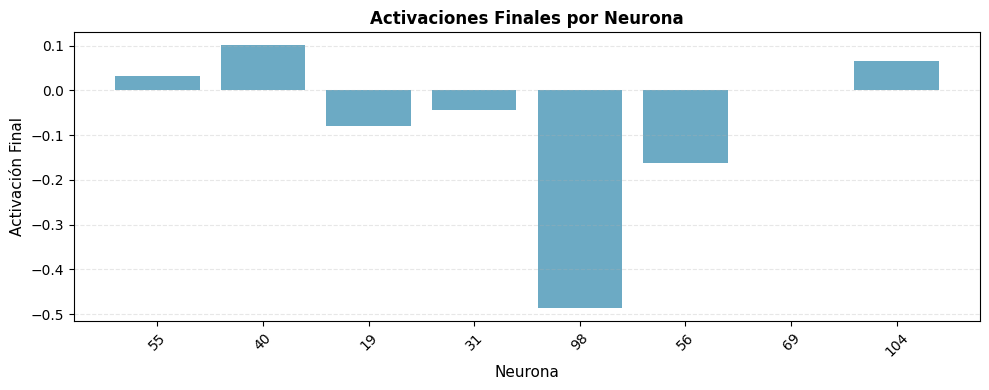

In [12]:
# Extraer activaciones finales
final_activations = [history[-1] for _, history in results.values()]

# Estadísticas
print("📊 Estadísticas de Activaciones:")
print(f"   Media: {np.mean(final_activations):.4f}")
print(f"   Std: {np.std(final_activations):.4f}")
print(f"   Min: {np.min(final_activations):.4f}")
print(f"   Max: {np.max(final_activations):.4f}")

# Visualizar distribución
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(range(len(neuron_indices)), final_activations, color='#2E86AB', alpha=0.7)
ax.set_xlabel('Neurona', fontsize=11)
ax.set_ylabel('Activación Final', fontsize=11)
ax.set_title('Activaciones Finales por Neurona', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(neuron_indices)))
ax.set_xticklabels([f'{idx}' for idx in neuron_indices], rotation=45)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

## 🔬 Experimento 3: Comparación entre Capas

Comparemos cómo evolucionan los features desde capas tempranas hasta tardías.

In [13]:
# Liberar recursos del visualizador anterior
visualizer.cleanup()

# Seleccionar capas de diferentes niveles
layers_to_compare = [
    'conv1',        # Capa muy temprana
    'layer1.1.conv2',  # Capa temprana
    'layer2.1.conv2',  # Capa media
    'layer3.1.conv2',  # Capa media-tardía
]

print("🎯 Capas a comparar:")
for i, layer in enumerate(layers_to_compare, 1):
    print(f"   {i}. {layer}")

INFO:src.utils.hooks:Removiendo hooks...
INFO:src.utils.hooks:✅ Todos los hooks removidos


✅ Recursos liberados
🎯 Capas a comparar:
   1. conv1
   2. layer1.1.conv2
   3. layer2.1.conv2
   4. layer3.1.conv2


In [14]:
# Generar visualizaciones para cada capa
layer_visualizations = {}
neurons_per_layer = 4  # Pocas neuronas para velocidad

for layer_name in layers_to_compare:
    print(f"\n{'='*60}")
    print(f"Procesando capa: {layer_name}")
    print(f"{'='*60}")
    
    # Crear visualizador para esta capa
    vis = FeatureVisualizer(model, layer_name, device=device)
    
    # Seleccionar neuronas aleatorias
    # El número de canales varía por capa, pero generalmente es suficiente
    selected_neurons = list(range(neurons_per_layer))  # Primeras N neuronas
    
    # Generar visualizaciones
    results = vis.generate_multiple_visualizations(
        neuron_indices=selected_neurons,
        image_size=(224, 224),
        iterations=100,  # Menos iteraciones para velocidad
        learning_rate=0.1,
        tv_weight=1e-4,
        l2_weight=1e-5,
        blur_freq=4,
        jitter=True,
        verbose=False
    )
    
    layer_visualizations[layer_name] = results
    
    # Limpiar
    vis.cleanup()

print(f"\n✅ Visualizaciones generadas para {len(layers_to_compare)} capas")

INFO:src.utils.hooks:ActivationHook inicializado con 1 capas objetivo
INFO:src.utils.hooks:Registrando hooks...
INFO:src.utils.hooks:✅ 1 hooks registrados exitosamente



Procesando capa: conv1
✅ FeatureVisualizer inicializado
   Capa objetivo: conv1
   Device: cpu

Procesando neurona 0

Procesando neurona 1

Procesando neurona 2

Procesando neurona 3


INFO:src.utils.hooks:Removiendo hooks...
INFO:src.utils.hooks:✅ Todos los hooks removidos
INFO:src.utils.hooks:ActivationHook inicializado con 1 capas objetivo
INFO:src.utils.hooks:Registrando hooks...
INFO:src.utils.hooks:✅ 1 hooks registrados exitosamente


✅ Recursos liberados

Procesando capa: layer1.1.conv2
✅ FeatureVisualizer inicializado
   Capa objetivo: layer1.1.conv2
   Device: cpu

Procesando neurona 0

Procesando neurona 1

Procesando neurona 2

Procesando neurona 3


INFO:src.utils.hooks:Removiendo hooks...
INFO:src.utils.hooks:✅ Todos los hooks removidos
INFO:src.utils.hooks:ActivationHook inicializado con 1 capas objetivo
INFO:src.utils.hooks:Registrando hooks...
INFO:src.utils.hooks:✅ 1 hooks registrados exitosamente


✅ Recursos liberados

Procesando capa: layer2.1.conv2
✅ FeatureVisualizer inicializado
   Capa objetivo: layer2.1.conv2
   Device: cpu

Procesando neurona 0

Procesando neurona 1

Procesando neurona 2

Procesando neurona 3


INFO:src.utils.hooks:Removiendo hooks...
INFO:src.utils.hooks:✅ Todos los hooks removidos
INFO:src.utils.hooks:ActivationHook inicializado con 1 capas objetivo
INFO:src.utils.hooks:Registrando hooks...
INFO:src.utils.hooks:✅ 1 hooks registrados exitosamente


✅ Recursos liberados

Procesando capa: layer3.1.conv2
✅ FeatureVisualizer inicializado
   Capa objetivo: layer3.1.conv2
   Device: cpu

Procesando neurona 0

Procesando neurona 1

Procesando neurona 2

Procesando neurona 3


INFO:src.utils.hooks:Removiendo hooks...
INFO:src.utils.hooks:✅ Todos los hooks removidos


✅ Recursos liberados

✅ Visualizaciones generadas para 4 capas


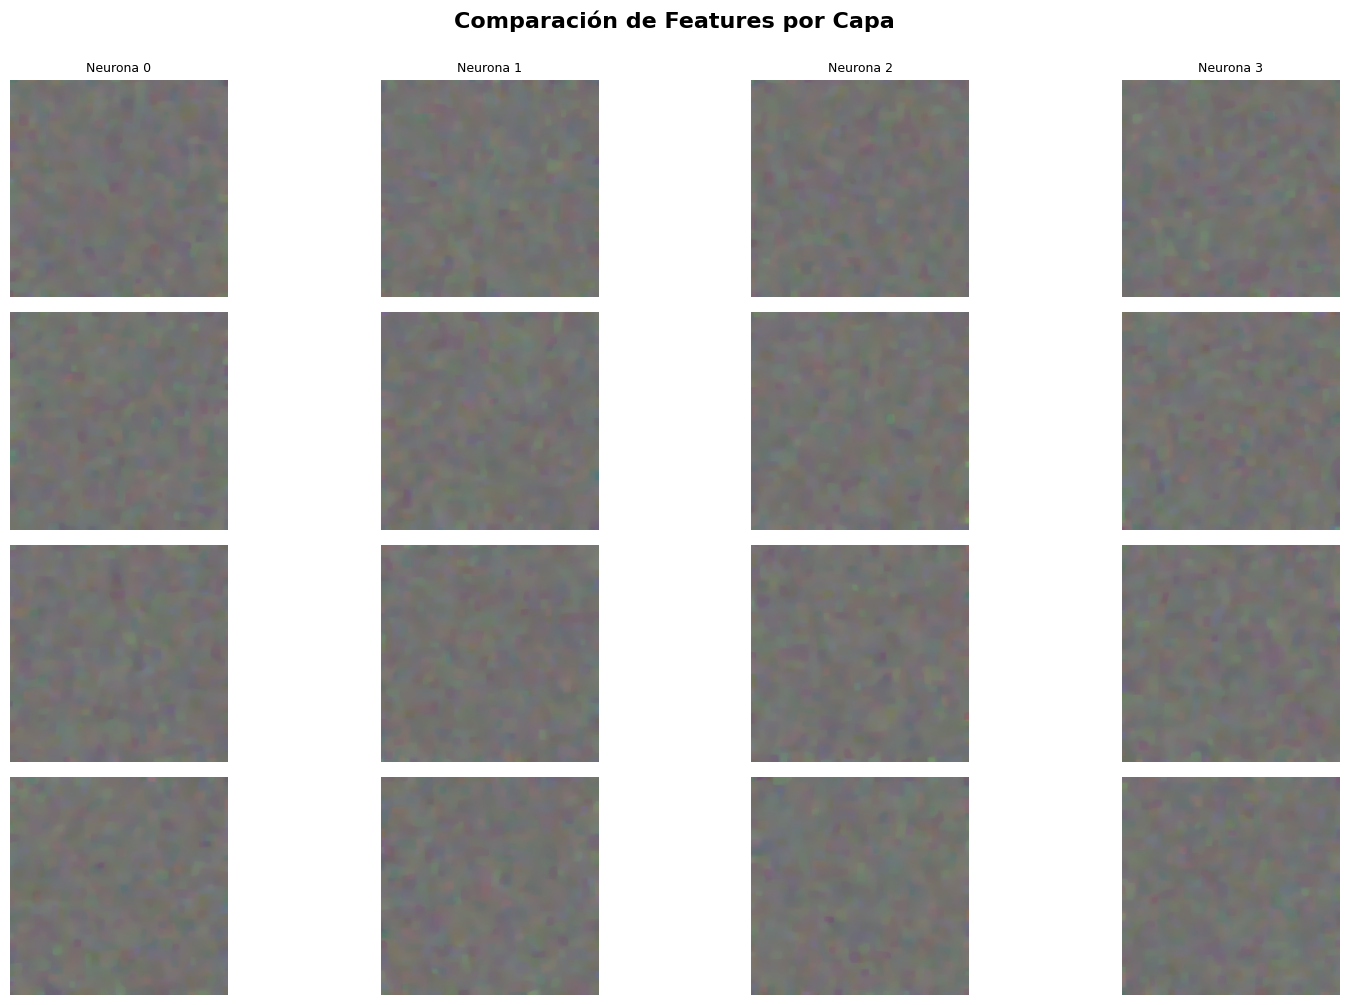

In [15]:
# Comparar visualizaciones
compare_layer_features(
    visualizations=layer_visualizations,
    num_neurons_per_layer=neurons_per_layer,
    figsize=(16, 10)
)

### 🔍 Observaciones sobre la Jerarquía de Features

**Patrón típico en CNNs:**

1. **Capas tempranas (conv1, layer1)**:
   - Detectan features de bajo nivel
   - Bordes simples, colores, gradientes
   - Patrones muy locales y específicos

2. **Capas medias (layer2, layer3)**:
   - Combinaciones de features tempranos
   - Texturas, formas simples
   - Patrones más complejos

3. **Capas tardías (layer4)**:
   - Features de alto nivel
   - Partes de objetos
   - Conceptos más abstractos

**¿Qué podemos aprender?**
- La red construye una jerarquía de representaciones
- Features simples se combinan para formar features complejos
- Cada capa "ve" el mundo de manera diferente

## 🧪 Experimento 4: Efecto de los Hiperparámetros

Exploremos cómo diferentes hiperparámetros afectan las visualizaciones.

In [16]:
# Crear nuevo visualizador
test_layer = 'layer2.0.conv1'
test_neuron = 10

vis_test = FeatureVisualizer(model, test_layer, device=device)

print(f"🧪 Probando diferentes configuraciones de regularización")
print(f"   Capa: {test_layer}")
print(f"   Neurona: {test_neuron}")

INFO:src.utils.hooks:ActivationHook inicializado con 1 capas objetivo
INFO:src.utils.hooks:Registrando hooks...
INFO:src.utils.hooks:✅ 1 hooks registrados exitosamente


✅ FeatureVisualizer inicializado
   Capa objetivo: layer2.0.conv1
   Device: cpu
🧪 Probando diferentes configuraciones de regularización
   Capa: layer2.0.conv1
   Neurona: 10


In [17]:
# Configuraciones a probar
configs = [
    {
        'name': 'Sin regularización',
        'tv_weight': 0.0,
        'l2_weight': 0.0,
        'blur_freq': 0
    },
    {
        'name': 'Regularización baja',
        'tv_weight': 1e-5,
        'l2_weight': 1e-6,
        'blur_freq': 10
    },
    {
        'name': 'Regularización media (default)',
        'tv_weight': 1e-4,
        'l2_weight': 1e-5,
        'blur_freq': 4
    },
    {
        'name': 'Regularización alta',
        'tv_weight': 1e-3,
        'l2_weight': 1e-4,
        'blur_freq': 2
    }
]

# Generar visualizaciones
config_results = {}

for config in configs:
    print(f"\n▶️ {config['name']}...")
    
    img, history = vis_test.generate_visualization(
        neuron_index=test_neuron,
        image_size=(224, 224),
        iterations=150,
        learning_rate=0.1,
        tv_weight=config['tv_weight'],
        l2_weight=config['l2_weight'],
        blur_freq=config['blur_freq'],
        jitter=True,
        verbose=False
    )
    
    config_results[config['name']] = (img, history)

vis_test.cleanup()
print("\n✅ Comparación completada")


▶️ Sin regularización...

▶️ Regularización baja...

▶️ Regularización media (default)...

▶️ Regularización alta...


INFO:src.utils.hooks:Removiendo hooks...
INFO:src.utils.hooks:✅ Todos los hooks removidos


✅ Recursos liberados

✅ Comparación completada


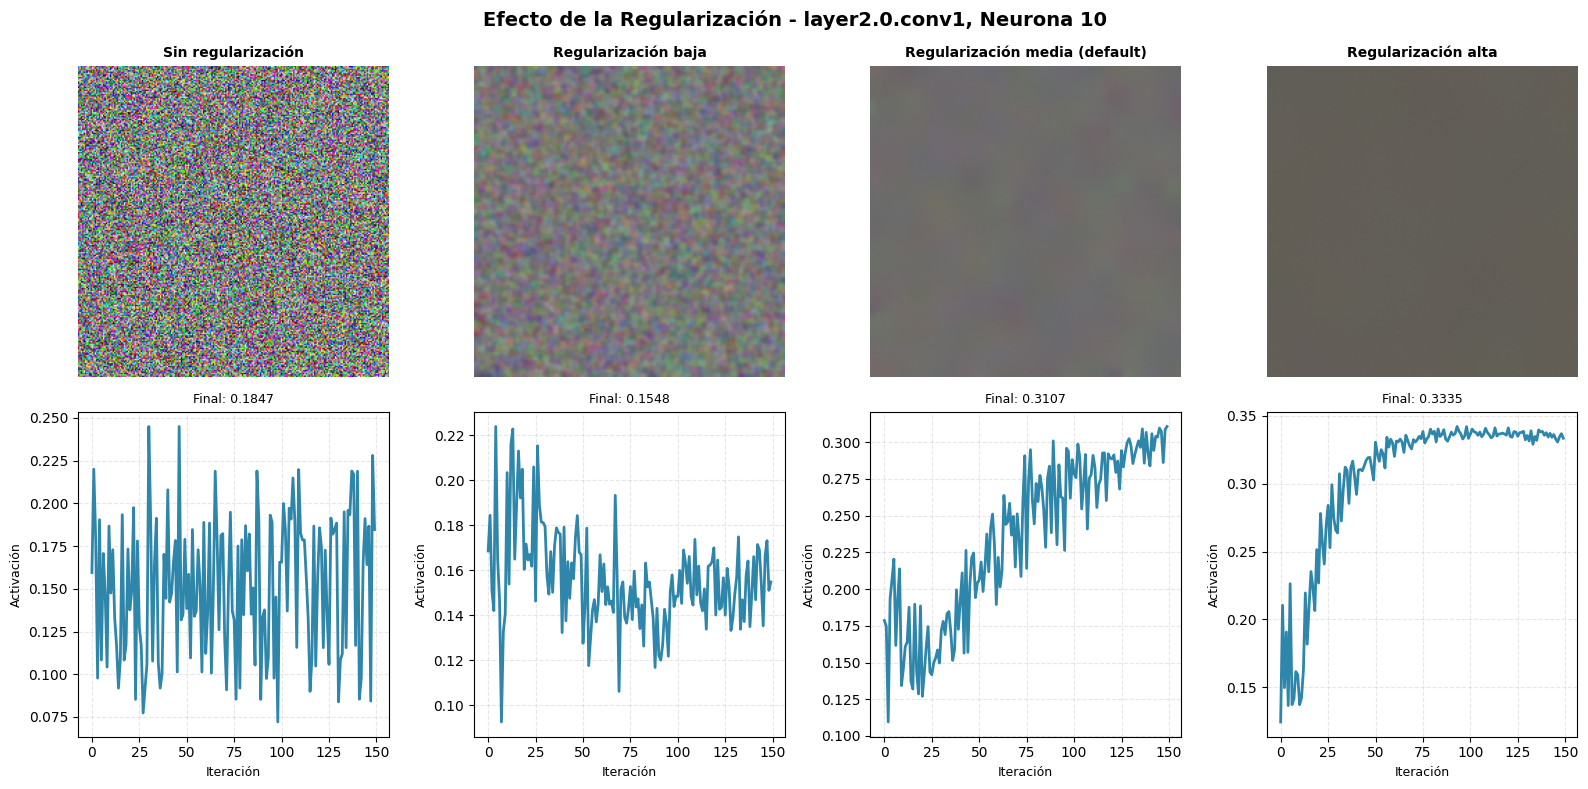

In [18]:
# Visualizar resultados
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

fig.suptitle(f'Efecto de la Regularización - {test_layer}, Neurona {test_neuron}',
            fontsize=14, fontweight='bold')

for idx, (config_name, (img, history)) in enumerate(config_results.items()):
    # Imagen
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(config_name, fontsize=10, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Curva de activación
    axes[1, idx].plot(history, linewidth=2, color='#2E86AB')
    axes[1, idx].set_xlabel('Iteración', fontsize=9)
    axes[1, idx].set_ylabel('Activación', fontsize=9)
    axes[1, idx].grid(True, alpha=0.3, linestyle='--')
    axes[1, idx].set_title(f'Final: {history[-1]:.4f}', fontsize=9)

plt.tight_layout()
plt.show()

### 📊 Análisis del Impacto de la Regularización

**Observaciones esperadas:**

1. **Sin regularización**:
   - Imagen con ruido de alta frecuencia
   - Activación muy alta pero imagen incomprensible
   - Sobreajuste al feature

2. **Regularización baja**:
   - Menos ruido pero aún artifacts
   - Balance entre activación e interpretabilidad

3. **Regularización media (recomendada)**:
   - Imágenes suaves e interpretables
   - Buena activación
   - Mejor trade-off

4. **Regularización alta**:
   - Imágenes muy suaves
   - Puede perder detalles importantes
   - Activación más baja

## 💾 Guardar Visualizaciones

Guardemos algunas visualizaciones para documentación.

In [19]:
# Crear directorio para resultados
output_dir = Path('../outputs/feature_visualizations')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"💾 Guardando visualizaciones en: {output_dir}")

# Guardar visualizaciones de layer2
for neuron_idx, (img, history) in results.items():
    # Guardar imagen
    img_path = output_dir / f'{target_layer.replace(".", "_")}_neuron_{neuron_idx}.png'
    Image.fromarray(img).save(img_path)

print(f"✅ {len(results)} imágenes guardadas")

💾 Guardando visualizaciones en: ..\outputs\feature_visualizations
✅ 4 imágenes guardadas


## 📊 Resumen de Aprendizajes

### ✅ Lo que hemos logrado:

1. **Implementado Activation Maximization**
   - Gradient ascent para optimizar inputs
   - Generación de imágenes sintéticas interpretables

2. **Técnicas de Regularización**
   - Total Variation Loss
   - L2 Norm Penalty
   - Blur y Jittering

3. **Análisis Multi-capa**
   - Visualización de jerarquía de features
   - Comparación entre capas tempranas y tardías

4. **Estudio de Hiperparámetros**
   - Impacto de la regularización
   - Trade-offs entre activación e interpretabilidad

---

### 🎯 Insights Clave:

**1. Jerarquía de Representaciones**
- Las redes construyen features de manera jerárquica
- Cada capa ve el mundo de forma diferente
- Features simples → complejos → abstractos

**2. Diversidad de Neuronas**
- Neuronas en la misma capa detectan features distintos
- Especialización funcional
- Redundancia puede existir

**3. Importancia de la Regularización**
- Sin regularización: activación alta pero ruido
- Con regularización: imágenes interpretables
- Balance es crítico

**4. Limitaciones de la Técnica**
- No todas las visualizaciones son interpretables
- Capas tardías son más difíciles de visualizar
- Puede no capturar toda la complejidad de la neurona

---

### 🔮 Próximos Pasos (Notebook 04):

1. **Neuron Probing**
   - Clasificadores lineales sobre activaciones
   - Análisis de qué información codifica cada capa

2. **Análisis Semántico**
   - Relación features → conceptos
   - Clustering de neuronas por función

3. **Activation Atlas**
   - Mapeo completo del espacio de features
   - Visualización de paisaje de activaciones

## 📚 Referencias y Recursos

**Papers Fundamentales:**
1. Olah et al. (2017) - "Feature Visualization"
2. Yosinski et al. (2015) - "Understanding Neural Networks Through Deep Visualization"
3. Erhan et al. (2009) - "Visualizing Higher-Layer Features of a Deep Network"

**Herramientas:**
- Lucid (TensorFlow): https://github.com/tensorflow/lucid
- PyTorch CNN Visualizations: https://github.com/utkuozbulak/pytorch-cnn-visualizations
- Captum: https://captum.ai/

**Conceptos Relacionados:**
- Adversarial Examples
- Style Transfer
- Neural Art
- Deep Dream

---

## ✅ Notebook Completado

**Estado:** ✅ Finalizado

**Logros:**
- [x] Implementar Activation Maximization
- [x] Técnicas de regularización
- [x] Visualizaciones multi-neurona
- [x] Comparación entre capas
- [x] Análisis de hiperparámetros

**Próximo Notebook:** `04_neuron_probing.ipynb`

---